In [1]:
%reload_ext autoreload
%autoreload 2

import time
from tqdm import tqdm
import numpy as np
import scipy as sp
import torch
import torch.nn.functional as F
from torch import nn
from torchvision.transforms import v2 as transforms

from matplotlib import pyplot as plt

from networkAlignmentAnalysis.models.registry import get_model
from networkAlignmentAnalysis.datasets import get_dataset
from networkAlignmentAnalysis.experiments.registry import get_experiment
from networkAlignmentAnalysis import utils
from networkAlignmentAnalysis import files
from networkAlignmentAnalysis import train

DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
print('using device: ', DEVICE)

using device:  cuda


In [3]:
# TODO
# 1.1. include additional AlignmentModel methods stored in extra class in base model

# 4. Rewrite existing analysis pipelines
# 5. SLURM!!!!

# i don't like how by_stride is buried in the layers. Rewrite 

# Figure out why convolutional alignment measurement is slow...
# still working on if it's possible to speed up measure_alignment for convolutional layers

# Basic alignment_comparison Analyses (or maybe for alignment_stats):
# - compare initial to final alignment...
# - compare initial alignment to delta weight norm...
# - observe alignment of delta weight
# - compare alignment to outgoing delta weight norm!

# Eigenfeature analyses:
# done: - start by just looking at amplitude of activity on each eigenvector within each layer
# - Determine contribution of each eigenfeature on performance with a eigenvector dropout experiment
# - Measure beta_adversarial (figure out how adversarial examples map onto eigenvectors)

# alignmentShaping.ipynb has an adversarial experiment worth looking at

# Consider Valentin's idea about measuring an error threshold given signal and noise for a given level of alignment
# e.g. plot a 2d heatmap comparing the noise amplitude and the average alignment
# and then think about how to apply this to network design...

100%|██████████| 10/10 [00:02<00:00,  4.49it/s]
4it [00:50, 12.51s/it]
100%|██████████| 10/10 [00:35<00:00,  3.58s/it]


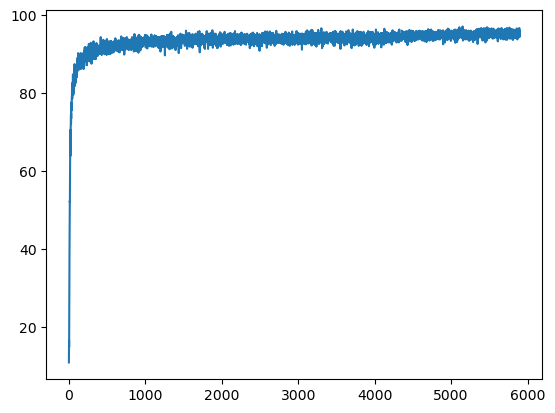

In [2]:
model_name = 'CNN2P2'
dataset_name = 'MNIST'
by_stride = True

net = get_model(model_name, build=True, dataset=dataset_name).to(DEVICE)
dataset = get_dataset(dataset_name, build=True, transform_parameters=net, device=DEVICE)

optimizer = torch.optim.Adam(net.parameters(), lr=1e-2)
results = train.train([net], [optimizer], dataset, num_epochs=100, alignment=False)

beta, eigenvalue, eigenvector = net.measure_eigenfeatures(dataset.test_loader, by_stride=by_stride)
dropout_results = train.eigenvector_dropout([net], dataset, [eigenvalue], [eigenvector], train_set=False, by_stride=by_stride)

plt.close('all')
plt.plot(results['accuracy'])
plt.show()

In [3]:
dropout_results.keys()

dict_keys(['progdrop_loss_high', 'progdrop_loss_low', 'progdrop_loss_rand', 'progdrop_acc_high', 'progdrop_acc_low', 'progdrop_acc_rand', 'dropout_fraction', 'by_layer', 'idx_dropout_layers'])

In [4]:
import matplotlib as mpl

def plot_dropout_results(dropout_results, dropout_parameters, dropout_type='nodes'):
    num_types = 1
    labels = [f"'net' - dropout {dropout_type}"]
    cmap = mpl.colormaps['Set1']
    alpha = 0.3
    msize = 10
    figdim = 3

    num_layers = dropout_results['progdrop_loss_high'].size(2)
    names = ['From high', 'From low', 'Random']
    num_exp = len(names)
    dropout_fraction = dropout_results['dropout_fraction']
    by_layer = dropout_results['by_layer']
    extra_name = 'by_layer' if by_layer else 'all_layers'
    extra_name += dropout_type

    # Get statistics across each network type for progressive dropout experiment
    print("measuring statistics on dropout analysis...")
    loss_mean_high, loss_se_high = utils.compute_stats_by_type(dropout_results['progdrop_loss_high'], 
                                                            num_types=num_types, dim=0, method='se')
    loss_mean_low, loss_se_low = utils.compute_stats_by_type(dropout_results['progdrop_loss_low'], 
                                                            num_types=num_types, dim=0, method='se')
    loss_mean_rand, loss_se_rand = utils.compute_stats_by_type(dropout_results['progdrop_loss_rand'], 
                                                            num_types=num_types, dim=0, method='se')

    acc_mean_high, acc_se_high = utils.compute_stats_by_type(dropout_results['progdrop_acc_high'], 
                                                            num_types=num_types, dim=0, method='se')
    acc_mean_low, acc_se_low = utils.compute_stats_by_type(dropout_results['progdrop_acc_low'], 
                                                            num_types=num_types, dim=0, method='se')
    acc_mean_rand, acc_se_rand = utils.compute_stats_by_type(dropout_results['progdrop_acc_rand'], 
                                                            num_types=num_types, dim=0, method='se')

    # Contract into lists for looping through to plot
    loss_mean = [loss_mean_high, loss_mean_low, loss_mean_rand]
    loss_se = [loss_se_high, loss_se_low, loss_se_rand]
    acc_mean = [acc_mean_high, acc_mean_low, acc_mean_rand]
    acc_se = [acc_se_high, acc_se_low, acc_se_rand]


    print("plotting dropout results...")
    # Plot Loss for progressive dropout experiment
    fig, ax = plt.subplots(num_layers, num_types, figsize=(num_types*figdim, num_layers*figdim), sharex=True, sharey=True, layout='constrained')
    ax = np.reshape(ax, (num_layers, num_types))

    for idx, label in enumerate(labels):
        for layer in range(num_layers):
            for iexp, name in enumerate(names):
                cmn = loss_mean[iexp][idx, :, layer]
                cse = loss_se[iexp][idx, :, layer]
                ax[layer, idx].plot(dropout_fraction, cmn, color=cmap(iexp), marker='.', markersize=msize, label=name)
                ax[layer, idx].fill_between(dropout_fraction, cmn+cse, cmn-cse, color=(cmap(iexp), alpha))
        
            if layer==0:
                ax[layer, idx].set_title(label)

            if layer==num_layers-1:
                ax[layer, idx].set_xlabel('Dropout Fraction')
                ax[layer, idx].set_xlim(0, 1)
            
            if idx==0:
                ax[layer, idx].set_ylabel('Loss w/ Dropout')

            if iexp==num_exp-1:
                ax[layer, idx].legend(loc='best')
    
    # self.plot_ready('prog_dropout_'+extra_name+'_loss')


    fig, ax = plt.subplots(num_layers, num_types, figsize=(num_types*figdim, num_layers*figdim), sharex=True, sharey=True, layout='constrained')
    ax = np.reshape(ax, (num_layers, num_types))

    for idx, label in enumerate(labels):
        for layer in range(num_layers):
            for iexp, name in enumerate(names):
                cmn = acc_mean[iexp][idx, :, layer]
                cse = acc_se[iexp][idx, :, layer]
                ax[layer, idx].plot(dropout_fraction, cmn, color=cmap(iexp), marker='.', markersize=msize, label=name)
                ax[layer, idx].fill_between(dropout_fraction, cmn+cse, cmn-cse, color=(cmap(iexp), alpha))

            ax[layer, idx].set_ylim(0, 100)

            if layer==0:
                ax[layer, idx].set_title(label)

            if layer==num_layers-1:
                ax[layer, idx].set_xlabel('Dropout Fraction')
                ax[layer, idx].set_xlim(0, 1)
            
            if idx==0:
                ax[layer, idx].set_ylabel('Accuracy w/ Dropout')

            if iexp==num_exp-1:
                ax[layer, idx].legend(loc='best')
    
    # self.plot_ready('prog_dropout_'+extra_name+'_accuracy')
                
    plt.show()

In [ ]:
plot_dropout_results()

In [3]:
# next steps:
# - finish eigenvector dropout methods -- need to do some linear algebra and decide how to renormalize
# - integrate into alignment_stats and observe results!!!
# --
# I'd like to make the conv handling code a bit smarter!
# And also more readable...
# Move some of the conv layer handling methods to internal AlignmentNetwork methods...
# Then integrate those methods into the 3 eigenfeature methods for easy reading and clear code
# --

In [ ]:
# places that use 'unfold' or should use it
# -- done -- AN.get_alignment_weights()
# -- done --AN.forward_eigenvector.dropout() # --- doesn't use it but it should!!! --- 
# -- done -- AN.measure_eigenfeatures()
# AN.measure_class_eigenfeatures()